# *Mcdonald's fast food market segmentation*

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic


In [8]:
# Load and preprocess the McDonald's dataset
mcdonalds = pd.read_csv('/content/drive/MyDrive/datasets/fynn lab intern /mcdonalds.csv')


In [10]:
mcdonalds.columns.to_list()
mcdonalds.shape

(1453, 15)

In [11]:
mcdonalds.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [12]:
# Select relevant columns and binarize 'Yes' responses
MD_x = mcdonalds.iloc[:, 0:11]
MD_x = (MD_x == "Yes").astype(int)

In [13]:
# Compute column means and round to 2 decimal places
col_means = MD_x.mean().round(2)

In [14]:
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(MD_x)
sd = np.sqrt(pca.explained_variance_)
variance = pca.explained_variance_ratio_

In [15]:
# Calculate cumulative variance
cum_variance = np.cumsum(variance)

In [16]:
# Create summary DataFrame
names = [f"PC{i}" for i in range(1, 12)]
summary = pd.DataFrame({
    "Standard deviation": sd,
    "Proportion of Variance": variance,
    "Cumulative Proportion": cum_variance
}, index=names).round(4)


In [17]:
# Transpose the summary for better readability
summary.T


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Standard deviation,0.7570,0.6075,0.5046,0.3988,0.3374,0.3103,0.2897,0.2751,0.2653,0.2488,0.2369
Proportion of Variance,0.2994,0.1928,0.1330,0.0831,0.0595,0.0503,0.0438,0.0395,0.0368,0.0324,0.0293
Cumulative Proportion,0.2994,0.4922,0.6253,0.7084,0.7679,0.8182,0.8620,0.9016,0.9383,0.9707,1.0000


In [19]:
# Create DataFrame for PCA components
components_df = pd.DataFrame(pca.components_, columns=MD_x.columns, index=names).round(4).T * -1



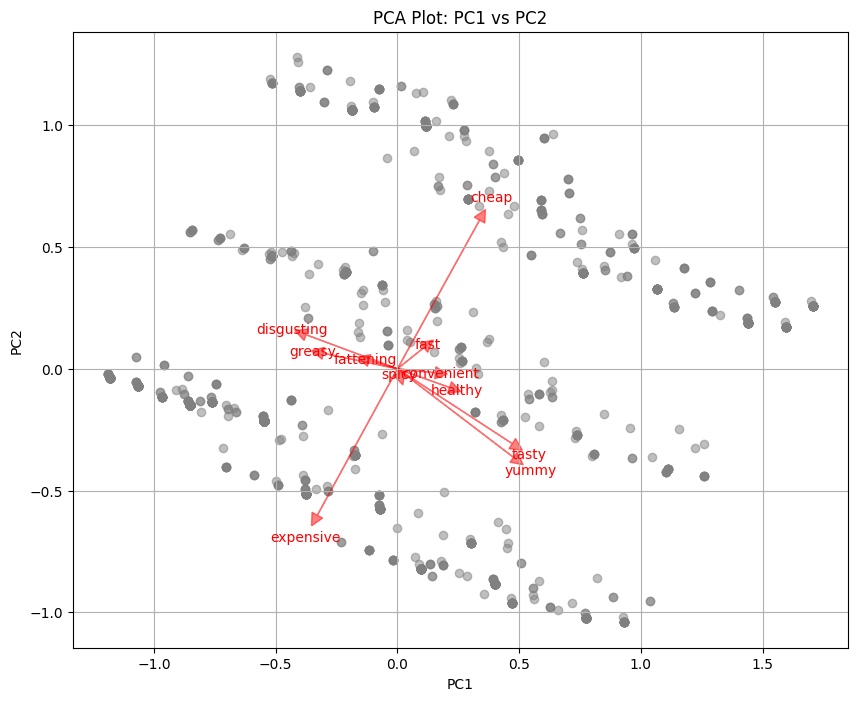

In [20]:
# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='grey', alpha=0.5)
for i in range(MD_x.shape[1]):
    plt.arrow(0, 0, components_df.iloc[i, 0], components_df.iloc[i, 1], color='r', alpha=0.5, head_width=0.05, head_length=0.05)
    plt.text(components_df.iloc[i, 0] * 1.15, components_df.iloc[i, 1] * 1.15, MD_x.columns[i], color='r', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot: PC1 vs PC2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [22]:
# KMeans clustering
kmeans_list = []
kmeans_labels = []
kmeans_centroids = []

In [23]:
for i in range(1, 9):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_list.append(kmeans.inertia_)
    kmeans_labels.append(kmeans.labels_)
    kmeans_centroids.append(kmeans.cluster_centers_)

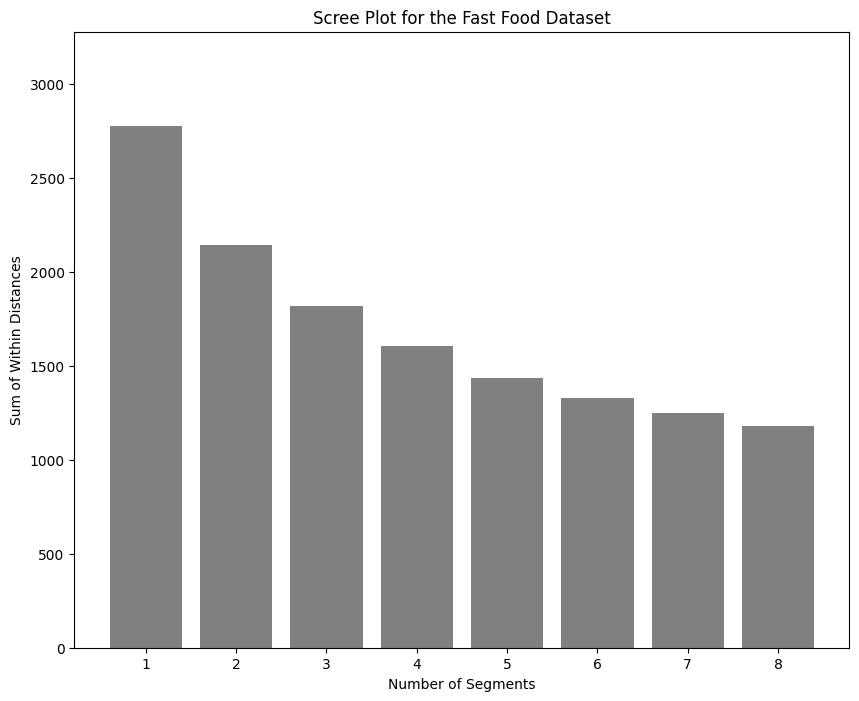

In [24]:

# Plot KMeans scree plot
plt.figure(figsize=(10, 8))
plt.bar(range(1, 9), kmeans_list, color='grey')
plt.ylim(0, max(kmeans_list) + 500)
plt.xlabel('Number of Segments')
plt.ylabel('Sum of Within Distances')
plt.title('Scree Plot for the Fast Food Dataset')
plt.show()

In [25]:

# Bootstrapping for KMeans clustering
def boot_kmeans(data, n_clusters_range, n_boot, kmeans_labels):
    rand_indices = {n_clusters: [] for n_clusters in n_clusters_range}
    for n_clusters in n_clusters_range:
        original_labels = kmeans_labels[n_clusters - 1]
        for _ in range(n_boot):
            boot_sample = data.sample(frac=1, replace=True)
            kmeans_boot = KMeans(n_clusters=n_clusters, n_init=10, random_state=np.random.randint(10000))
            kmeans_boot.fit(boot_sample)
            boot_labels = kmeans_boot.predict(data)
            rand_index = adjusted_rand_score(original_labels, boot_labels)
            rand_indices[n_clusters].append(rand_index)
    return rand_indices


In [30]:
# Perform bootstrapping and calculate adjusted Rand index
n_clusters_range = range(1, 9)
n_boot = 100
rand_indices = boot_kmeans(MD_x, n_clusters_range, n_boot, kmeans_labels)



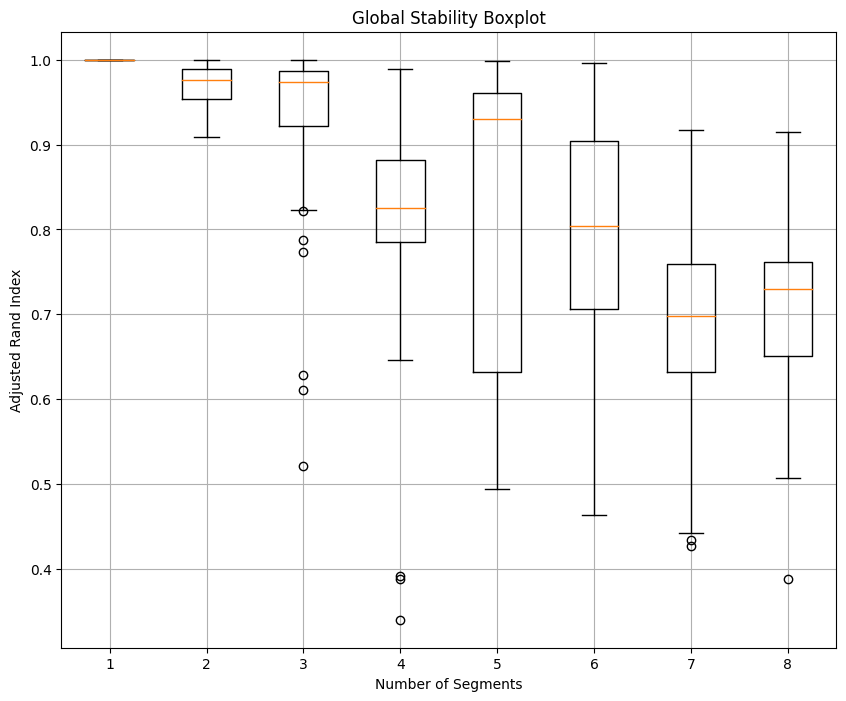

In [31]:
# Boxplot for adjusted Rand index
plt.figure(figsize=(10, 8))
plt.boxplot([rand_indices[n_clusters] for n_clusters in n_clusters_range], labels=n_clusters_range)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability Boxplot')
plt.grid(True)
plt.show()


In [32]:
# Calculate Euclidean distances and similarities
centroids = kmeans_centroids[3]
distances = euclidean_distances(MD_x, centroids)
scaler = MinMaxScaler()
similarities = scaler.fit_transform(distances)
similarities = 1 - similarities

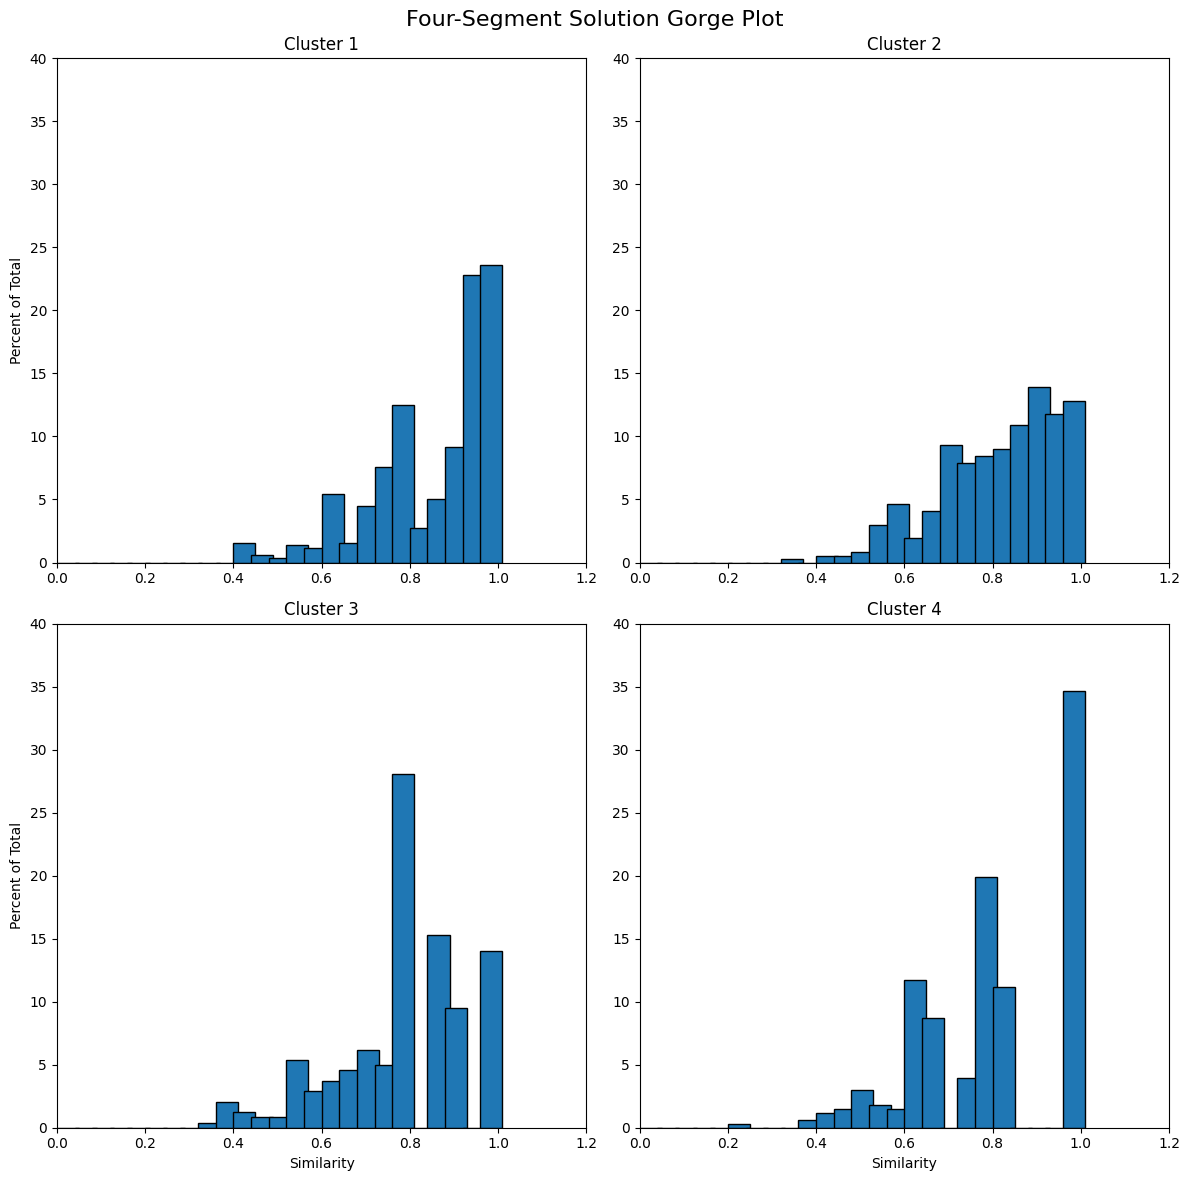

In [33]:
# Plot similarities for four clusters
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Four-Segment Solution Gorge Plot', fontsize=16)

for i in range(4):
    row, col = divmod(i, 2)
    cluster_similarities = similarities[kmeans_labels[3] == i, i]
    hist, bin_edges = np.histogram(cluster_similarities, bins=25, range=(0, 1))
    percentage = (hist / len(cluster_similarities)) * 100
    axs[row, col].bar(bin_edges[:-1], percentage, width=0.05, edgecolor='black', align='edge')
    axs[row, col].set_title(f'Cluster {i+1}')
    axs[row, col].set_xlim(0, 1.2)
    axs[row, col].set_ylim(0, 40)
    if row == 1:
        axs[row, col].set_xlabel('Similarity')
    if col == 0:
        axs[row, col].set_ylabel('Percent of Total')

plt.tight_layout()
plt.show()

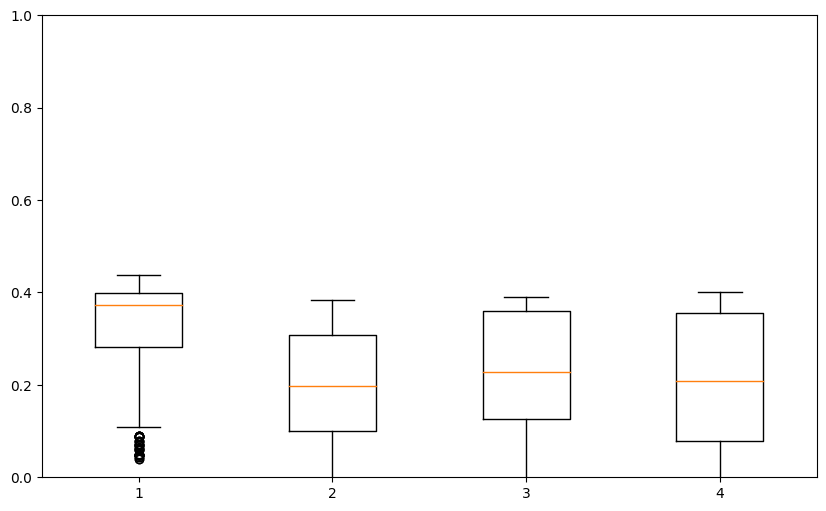

In [34]:
# Silhouette analysis for KMeans clustering
def silhouette_vals_per_cluster(X, labels):
    silhouette_vals = silhouette_samples(X, labels)
    return [silhouette_vals[labels == i] for i in range(len(np.unique(labels)))]

silhouette_vals = silhouette_vals_per_cluster(MD_x, kmeans_labels[3])

plt.figure(figsize=(10, 6))
plt.boxplot(silhouette_vals, labels=range(1, len(silhouette_vals) + 1))
plt.ylim(0, 1)
plt.show()

In [35]:
# Gaussian Mixture Models (GMM) for clustering
n_clusters_range = range(2, 9)
aic, bic, log_likelihood = [], [], []

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    aic.append(gmm.aic(MD_x))
    bic.append(gmm.bic(MD_x))
    log_likelihood.append(gmm.score(MD_x) * len(MD_x))

icl = [i + j for i, j in zip(bic, log_likelihood)]



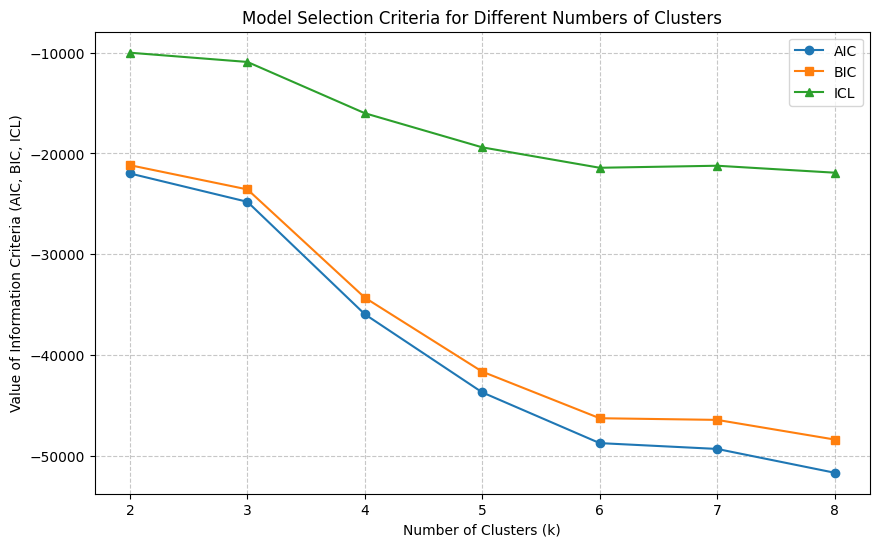

In [36]:
# Plot model selection criteria for GMM
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, aic, marker='o', label='AIC')
plt.plot(n_clusters_range, bic, marker='s', label='BIC')
plt.plot(n_clusters_range, icl, marker='^', label='ICL')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Value of Information Criteria (AIC, BIC, ICL)')
plt.title('Model Selection Criteria for Different Numbers of Clusters')
plt.legend()
plt.xticks(n_clusters_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [37]:
# Compare KMeans and GMM clustering results
labels = kmeans_labels[3]

gmm = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm.fit(MD_x)
gmm_labels = gmm.predict(MD_x)

comparison_df = pd.DataFrame({'KMeans': labels, 'GMM': gmm_labels})

contingency_table = pd.crosstab(comparison_df['KMeans'], comparison_df['GMM'])

print("Contingency Table:")
print(contingency_table)


Contingency Table:
GMM       0   1   2    3
KMeans                  
0       449   1  42   21
1       288  36   5   37
2         0  87   2  153
3         0   8  77  247


In [38]:
# Log-likelihood comparison for GMM with different initializations
gmm1 = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm1.fit(MD_x)
log_lik1 = gmm1.score(MD_x) * len(MD_x)

gmm2 = GaussianMixture(n_components=4, n_init=10, random_state=5678)
gmm2.fit(MD_x)
log_lik2 = gmm2.score(MD_x) * len(MD_x)

print(f"Log-likelihood for the first GMM: {log_lik1}")
print(f"Log-likelihood for the second GMM: {log_lik2}")

Log-likelihood for the first GMM: 18280.115101343403
Log-likelihood for the second GMM: 19586.60003085229


In [39]:
# Map 'Like' values to numerical scale
like_mapping = {
    'I love it!+5': 5, 'I hate it!-5': -5, '+4': 4, '+3': 3, '+2': 2,
    '+1': 1, '0': 0, '-1': -1, '-2': -2, '-3': -3, '-4': -4
}

mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)

# Assign cluster memberships from KMeans and GMM
mcdonalds['Cluster_kmeans'] = labels
mcdonalds['Cluster_gmm'] = gmm_labels

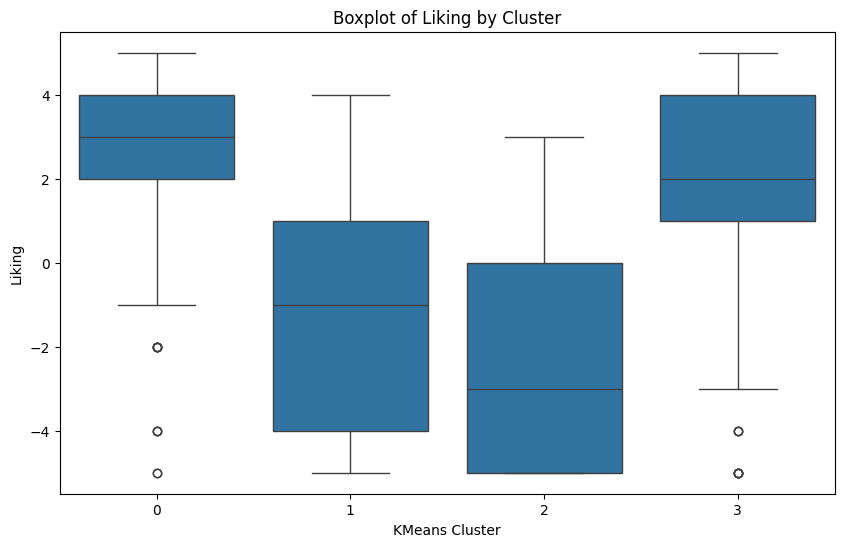

In [40]:
# Boxplot to compare 'Like.n' across KMeans clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_kmeans', y='Like.n', data=mcdonalds)
plt.title('Boxplot of Liking by Cluster')
plt.xlabel('KMeans Cluster')
plt.ylabel('Liking')
plt.show()


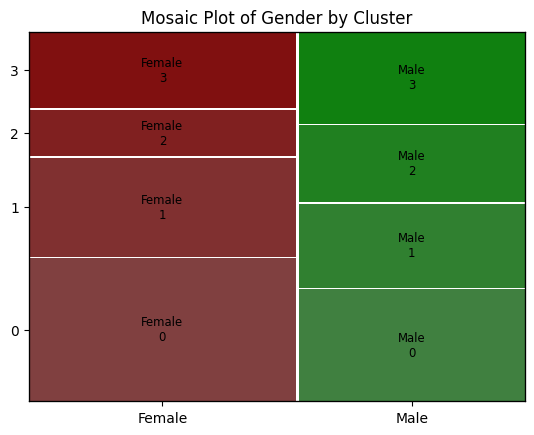

In [41]:
# Mosaic plot to compare gender distribution across KMeans clusters
gender_cluster_table = pd.crosstab(mcdonalds['Gender'], mcdonalds['Cluster_kmeans'])
mosaic(gender_cluster_table.stack(), title='Mosaic Plot of Gender by Cluster')
plt.show()

In [42]:
# Logistic regression to predict 'Like.n'
logit_model = LogisticRegression()
logit_model.fit(MD_x, mcdonalds['Like.n'])
coef_df = pd.DataFrame({
    'Variable': MD_x.columns,
    'Coefficient': logit_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
print(coef_df)

Logistic Regression Coefficients:
      Variable  Coefficient
10  disgusting     2.103958
8    expensive     0.198293
2        spicy     0.181745
4       greasy     0.180844
6        cheap     0.069340
3    fattening     0.028333
5         fast    -0.436878
9      healthy    -0.700698
7        tasty    -1.079190
1   convenient    -1.342129
0        yummy    -1.737275


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
